<b><u>Observations</b></u>
<p>1. observation</p>
<p>2. observation</p>
<p>3. observation</p>

In [12]:
# Dependencies
import numpy as np
import random
import json
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wrapper for OpenWeatherMap
# Will use this to view sample JSON API response
import openweathermapy.core as owm

# Dependencies for downloading and uncompressing list of cities from OpenWeatherMap
import urllib.request
import gzip

# Set the seaborn chart style
sns.set()

# Increase the size of the bubble charts
plt.rcParams["figure.figsize"] = [10,8]

In [13]:
# Print out a sample JSON API response
settings = {"units": "imperial", "appid": api_key}
pprint(owm.get_current(2172797, **settings))

{'base': 'stations',
 'clouds': {'all': 75},
 'cod': 200,
 'coord': {'lat': -16.92, 'lon': 145.77},
 'dt': 1521928800,
 'id': 2172797,
 'main': {'humidity': 83,
          'pressure': 1006,
          'temp': 80.6,
          'temp_max': 80.6,
          'temp_min': 80.6},
 'name': 'Cairns',
 'sys': {'country': 'AU',
         'id': 8166,
         'message': 0.0039,
         'sunrise': 1521836495,
         'sunset': 1521879852,
         'type': 1},
 'visibility': 10000,
 'weather': [{'description': 'shower rain',
              'icon': '09n',
              'id': 521,
              'main': 'Rain'}],
 'wind': {'deg': 150, 'speed': 14.99}}


<h1>Download City List</h1>

In [14]:
# This section downloads the list of cities and IDs that OpenWeatherMap uses

# File names
city_index_zip_file = "city.list.json.gz"
city_index_json_file = 'city.list.json'

# Download file
urllib.request.urlretrieve ("http://bulk.openweathermap.org/sample/city.list.json.gz", city_index_zip_file)

# Uncompress gzip file to json
inF = gzip.open(city_index_zip_file, 'rb')
outF = open(city_index_json_file, 'wb')
outF.write(inF.read())
inF.close()
outF.close()

# Read json file into a dataframe
city_index_df = pd.read_json(city_index_json_file)

# Print top five rows
city_index_df.head()

,coord,country,id,name
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,GorkhÄ�
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of HaryÄ�na
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka


<h1>Generate City List</h1>

In [15]:
# This section selects 555 random cities from the above city index dataframe

# Start by creating an empty dataframe
random_city_df = pd.DataFrame(columns=['coord', 'country', 'id', 'name', 'lon', 'lat'])

# Set counter to zero for looping
counter = 0

# Set total number of random cities
total_cities = 555

# Loop while counter is less than number of cities
while counter < total_cities:
    
    # Pick a random row (must be length - 1 since row starts at 0)
    row = random.randint(0, len(city_index_df)-1)
    
    # If ID is already in the dataframe then do nothing repeat loop
    if any(random_city_df.id == city_index_df['id'][row]):
        pass
    
    # If ID isn't in the dataframe then add that row to the dataframe, including latitude and longitude
    else:
        random_city_df.loc[counter] = city_index_df.iloc[row,:]
        random_city_df.lat[counter] = city_index_df['coord'][row]['lat']
        random_city_df.lon[counter] = city_index_df['coord'][row]['lon']
        counter = counter + 1
        
# Change latitude and longitude columns from object to float
random_city_df[['lat','lon']] = random_city_df[['lat','lon']].apply(pd.to_numeric)

# Remove coordinate column, since we parsed out that data
del random_city_df['coord']

<h1>Weather API Call</h1>

In [17]:
# This section does the API calls from OpenWeatherMap

# Create empty lists for temperature, humidity, cloudiness and windspeed
# This will get added to the dataframe of cities
city_temp_list = []
city_humidity_list = []
city_cloudiness_list = []
city_windspeed_list = []

# Loop through the total number of cities
for index in range(total_cities):
    
    # Print out 
    print(f"Request {index+1} of {total_cities}: {random_city_df['name'][index]}")
    
    # Create the URL
    url = "http://api.openweathermap.org/data/2.5/weather?APPID="+api_key+"&units=imperial&id="+str(random_city_df.id[index])
    
    # Print the URl but mask the api key
    print("http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id="+str(random_city_df.id[index]))

    # Do the API call
    response = requests.get(url)
    
    # Convert API response to JSON
    data = response.json()
    
    # Grab temperature, humidity, cloudiness and windspeed and add it to their respective list    
    city_temp_list.append(data['main']['temp'])
    city_humidity_list.append(data['main']['humidity'])
    city_cloudiness_list.append(data['clouds']['all'])
    city_windspeed_list.append(data['wind']['speed'])

# Add temperature, humidity, cloudiness and windspeed as a column in the dataframe
random_city_df['temp'] = city_temp_list
random_city_df['humidity'] = city_humidity_list
random_city_df['cloudiness'] = city_cloudiness_list
random_city_df['windspeed'] = city_windspeed_list

Request 1 of 555: Crecchio
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3177844
Request 2 of 555: Hottenbach
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6553605
Request 3 of 555: Berg
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2950772
Request 4 of 555: Camphin-en-Pevele
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3028946
Request 5 of 555: Jerichower Land
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3302158
Request 6 of 555: Bengel
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2951095
Request 7 of 555: Yudongzi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1785961
Request 8 of 555: Selma
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4727785
Request 9 of 555: Aldea del Obispo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&u

Request 74 of 555: Potos (Thassos)
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6692234
Request 75 of 555: Le Plessis-Brion
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3002677
Request 76 of 555: Budayuan
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2038258
Request 77 of 555: McConnell AFB
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7315256
Request 78 of 555: Rising Sun
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4263736
Request 79 of 555: Santa MarÃ­a de las Hoyas
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6361201
Request 80 of 555: Mountain House
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5375407
Request 81 of 555: Valley
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2635022
Request 82 of 555: Lumeje
http://api.openweathermap.o

Request 146 of 555: Regierungsbezirk Darmstadt
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2938912
Request 147 of 555: Plaudren
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6437330
Request 148 of 555: Yallingup
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2057614
Request 149 of 555: Husby
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2897200
Request 150 of 555: Plosorejo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7081648
Request 151 of 555: Guanghua
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7661855
Request 152 of 555: Huolong
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1885697
Request 153 of 555: Temple Hills
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=4371053
Request 154 of 555: Svortland
http://api.openweathermap.org/data/2.5

Request 218 of 555: Cigangsa
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=8045070
Request 219 of 555: Gratot
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3014846
Request 220 of 555: La Horne
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2793552
Request 221 of 555: Preesall
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2639934
Request 222 of 555: Nanzhuang
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=7517930
Request 223 of 555: Linshui
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1280706
Request 224 of 555: Oblast Plovdiv
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=728194
Request 225 of 555: Villamassargia
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2522748
Request 226 of 555: Kotla
http://api.openweathermap.org/data/2.5/weather?APPID=

Request 290 of 555: Strassen
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2960054
Request 291 of 555: San Luis
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3621768
Request 292 of 555: Lisala
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=211734
Request 293 of 555: Dobitschen
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6550532
Request 294 of 555: Duba-Yurt
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=564821
Request 295 of 555: Plataria
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=255013
Request 296 of 555: Hjelmeland
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3152565
Request 297 of 555: Aurions-Idernes
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6450411
Request 298 of 555: Bresch
http://api.openweathermap.org/data/2.5/weather?APPID=x

Request 361 of 555: Coalinga
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5338196
Request 362 of 555: Olleros de Tera
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3115135
Request 363 of 555: San Antonio
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1690295
Request 364 of 555: Bindura
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=895061
Request 365 of 555: Miremont
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6431686
Request 366 of 555: Topton
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5215826
Request 367 of 555: Jaguariaiva
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3460214
Request 368 of 555: Arceo
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3129762
Request 369 of 555: Willington
http://api.openweathermap.org/data/2.5/weather?APPI

Request 433 of 555: Howick
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2189715
Request 434 of 555: Saint-Sauveur-sur-Ecole
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=2977006
Request 435 of 555: Siqian
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1794173
Request 436 of 555: Marituba
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3457646
Request 437 of 555: Elorz
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3123398
Request 438 of 555: Salas de los Infantes
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6356579
Request 439 of 555: Mae Tha
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1152180
Request 440 of 555: Shkinâ€™
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=494020
Request 441 of 555: Weimar
http://api.openweathermap.org/data/2.5/wea

Request 504 of 555: Agasegyhaza
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3056391
Request 505 of 555: Volpara
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3163980
Request 506 of 555: Su-ngai Padi
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=1610303
Request 507 of 555: Besse
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=6613716
Request 508 of 555: Bruno
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=5910266
Request 509 of 555: Recas
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=669058
Request 510 of 555: Muá¸©Ä�fazÌ§at á¸¨aá¸‘ramawt
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=75411
Request 511 of 555: El Molino
http://api.openweathermap.org/data/2.5/weather?APPID=xxxxx&units=imperial&id=3683778
Request 512 of 555: Birkenbeul
http://api.openweathermap.org/data/2.5/wea

In [18]:
# Export city dataframe as CSV
random_city_df.to_csv("weather_data.csv", encoding='utf-8')

<h1>Print Charts</h1>

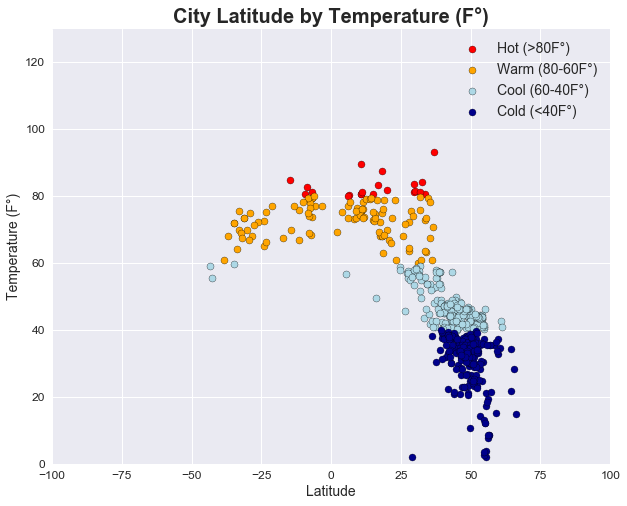

In [33]:
# This section prints a scatter plot of latitude by temperature

# Variables for hot, warm and cool
hot_temp = 80
warm_temp = 60
cold_temp = 40

# Create subsets of the dataframe to group by hot, warm, cool and cold temperatures
hot_cities = np.ma.masked_where((random_city_df['temp'] <= hot_temp), random_city_df['temp'])
warm_cities = np.ma.masked_where((random_city_df['temp'] > hot_temp) | (random_city_df['temp'] <= warm_temp), 
                                 random_city_df['temp'])
cool_cities = np.ma.masked_where((random_city_df['temp'] > warm_temp) | (random_city_df['temp'] <= cold_temp), random_city_df['temp'])
cold_cities = np.ma.masked_where((random_city_df['temp'] >= cold_temp), random_city_df['temp'])

# Clear the plot, just in case
plt.clf()

# Create scatter plots
plt.scatter(random_city_df['lat'], hot_cities, marker="o", facecolors='red', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], warm_cities, marker="o", facecolors='orange', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cool_cities, marker="o", facecolors='lightblue', edgecolors="black", alpha=1)
plt.scatter(random_city_df['lat'], cold_cities, marker="o", facecolors='darkblue', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Temperature (F\N{DEGREE SIGN})", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Temperature (F\N{DEGREE SIGN})", fontsize=14)

# Legend
plt.legend((f'Hot (>{hot_temp}F\N{DEGREE SIGN})',f'Warm ({hot_temp}-{warm_temp}F\N{DEGREE SIGN})', 
            f'Cool ({warm_temp}-{cold_temp}F\N{DEGREE SIGN})',f'Cold (<{cold_temp}F\N{DEGREE SIGN})'),loc='best', prop={'size': 14})

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(0,130)

# Save the figure
plt.savefig("LatByTemp.png")

# Display scatter chart
plt.show()

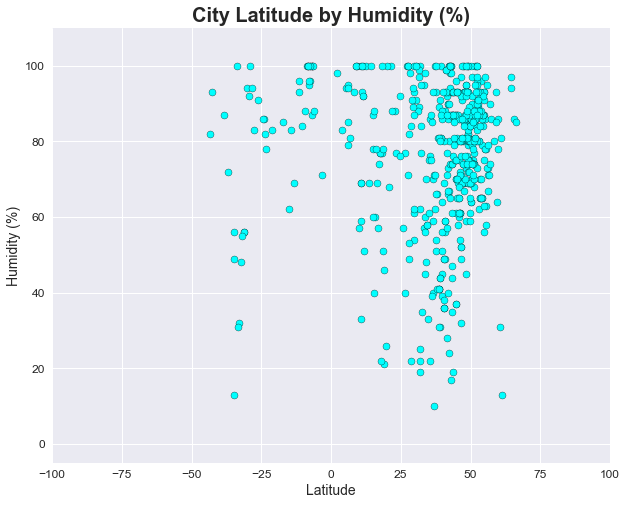

In [21]:
# This section prints a scatter plot of latitude by humidity

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['humidity'], marker="o", facecolors='aqua', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Humidity (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,110)

# Save the figure
plt.savefig("LatByHumidity.png")

# Display scatter chart
plt.show()

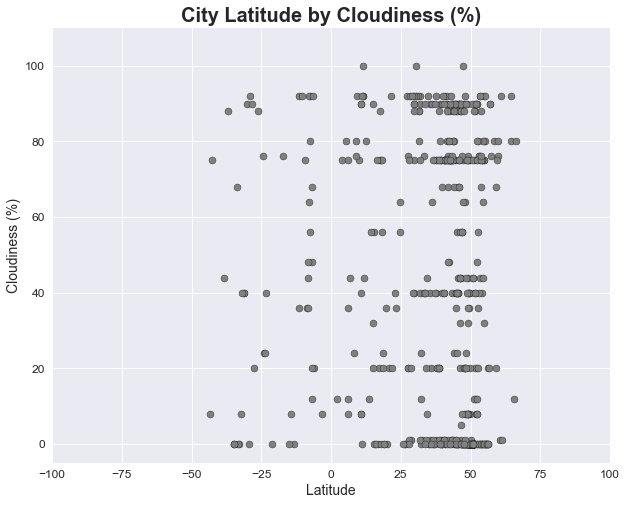

In [22]:
# This section prints a scatter plot of latitude by cloudiness

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['cloudiness'], marker="o", facecolors='gray', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Cloudiness (%)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,110)

# Save the figure
plt.savefig("LatByCloudiness.png")

# Display scatter plot
plt.show()

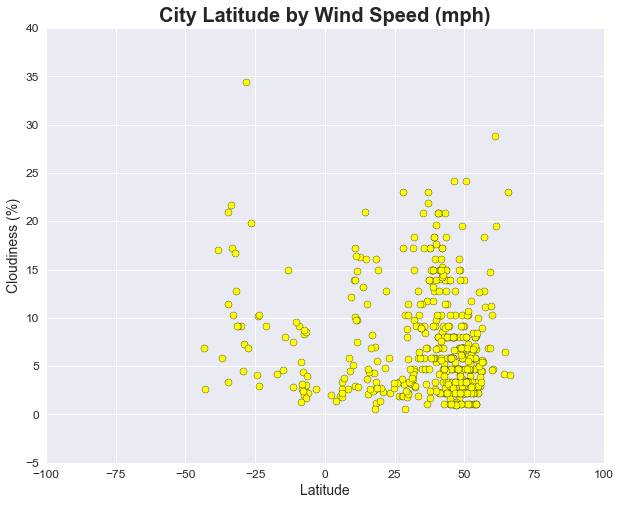

In [23]:
# This section prints a scatter plot of latitude by windspeed

# Clear plot, just in case
plt.clf()

# Create scatter plot
plt.scatter(random_city_df['lat'], random_city_df['windspeed'], marker="o", facecolors='yellow', edgecolors="black", alpha=1)

# Create a title, x label, and y label
plt.title("City Latitude by Wind Speed (mph)", fontsize=20, fontweight="bold")
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Cloudiness (%)", fontsize=14)

# Set size of x and y tick labels
plt.tick_params(labelsize=12)

# Set x and y limits
plt.xlim(-100,100)
plt.ylim(-5,40)

# Save the figure
plt.savefig("LatByWindspeed.png")

# Display scatter plot
plt.show()